<a href="https://colab.research.google.com/github/RGologorsky/CS-182-final-project/blob/master/01_superres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Super resolution**

Baseline: image -> image

Next steps: kspace to kspace

In [0]:
PROJ       = "fastmri"
ds_name    = "knee_singlecoil_val"

In [0]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                  # path to project on PROJ
PROJ_PATH.mkdir(parents=True, exist_ok=True) # make dir in PROJ to house Github

In [0]:
# imports
%run "$PROJ_PATH/common_constants_env.ipynb" # defines DS2FN - dict of dataset name: (filename, url)

pip install fastai2


SyntaxError: ignored

In [0]:
from fastai2.vision.gan import *

# **Data path**

In [0]:
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

In [0]:
path_ds = PROJ_PATH/"data"/DS2DIR[ds_name]
path_ds

Path('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val')

In [0]:
path_hr   = path_ds/"images"/"highres"
path_lr   = path_ds/"images"/"crappy"
path_ks   = path_ds/"ks"

path_hr.mkdir(parents=True, exist_ok=True)
path_lr.mkdir(parents=True, exist_ok=True)
path_ks.mkdir(parents=True, exist_ok=True)

# **Highres images**

Save each slice in a h5 kspace volume. Seperately save each h5 kspace volume shape and attributes.

In [0]:
def get_h5_files(path, recurse=True, folders=None):
  return get_files(path, extensions=".h5", recurse=recurse, folders=folders)

In [0]:
%%time
fnames_all = get_h5_files(path_ds)

CPU times: user 1.83 ms, sys: 866 µs, total: 2.7 ms
Wall time: 9.73 ms


In [0]:
fnames_test = fnames_all[:2]
fnames_test

(#2) [Path('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000052.h5'),Path('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000631.h5')]

# Save images (if needed)

In [0]:
sys.path.append('/content/fastMRI/common')

In [0]:
%run "$PROJ_PATH/save_images.ipynb"

In [0]:
s = slice_saver(path_hr, path_ks)
fn = fnames_test[0]
print(fn)
s(fn)

/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000052.h5


In [0]:
i = 0
img = Image.open(f"{path_hr}/{fn.stem}_slice_{i}.png")

In [0]:
img.shape

(640, 372)

In [0]:
# if slices not saved, do
%%time
parallel(slice_saver(path_hr, path_ks), fnames_test)

TypeError: ignored

In [0]:
??parallel

In [0]:
%%time
filenames = get_h5_files(path_ds)

CPU times: user 2.21 ms, sys: 173 µs, total: 2.39 ms
Wall time: 7.1 ms


In [0]:
%%time
objs = [h5py.File(f,'r') for f in filenames]

CPU times: user 52.3 ms, sys: 82.2 ms, total: 135 ms
Wall time: 57.2 s


In [0]:
%%time
attrs = [dict(o.attrs) for o in objs]

CPU times: user 18.1 ms, sys: 2.9 ms, total: 21 ms
Wall time: 22.4 ms


In [0]:
%%time
pulses = [a['acquisition'] for a in attrs]

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 15.7 µs


In [0]:
%time
unique_pulses, counts_pulses = np.unique(pulses, return_counts=True)
unique_pulses, counts_pulses

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


(array(['CORPDFS_FBK', 'CORPD_FBK'], dtype='<U11'), array([19, 21]))

In [0]:
%time
np_shapes = [hf["kspace"][()].shape for i,hf in enumerate(objs)]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [0]:
dims = [str((b,c)) for _,b,c in np_shapes]

In [0]:
unique_dims = set(dims)
unique_dims

{'(640, 372)', '(640, 400)', '(640, 454)', '(640, 644)'}

In [0]:
count_dims = {}
for dim in dims:
  if dim in count_dims: count_dims[dim] += 1
  else: count_dims[dim] = 1
count_dims

{'(640, 372)': 37, '(640, 400)': 1, '(640, 454)': 1, '(640, 644)': 1}

In [0]:
file = filenames[0]
hf = h5py.File(file, 'r')
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPD_FBK', 'max': 0.0007207574118101356, 'norm': 0.18467329268499744, 'patient_id': 'aec97d55e8719bc06b7b23b82ca97c3e3ef351a4a0279c7169e32707fe4a958c'}


In [0]:
header = hf["ismrmrd_header"]

In [0]:
def test(t): print(f"idx {t[0]}, shape {t[1].shape}")

In [0]:
kspace = hf["kspace"][()]

In [0]:
hf.attrs[""]

In [0]:
file

Path('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000052.h5')

In [0]:
file.stem

'file1000052'

In [0]:
def test(t): print(f"idx {t[0]}, shape {t[1].shape}")
slices_enum = [(i,kspace[i]) for i in range(kspace.shape[0])]
parallel(test, slices_enum, n_workers=2)

In [0]:
from torchvision.utils import save_image


In [0]:
%pwd

'/content'

In [0]:
img_slice = slices_enum[0][1]

In [0]:
type(img_slice)

numpy.ndarray

In [0]:
torch.save(img_slice, PROJ_PATH/"test.pt")

In [0]:
from PIL import Image

In [0]:
img = Image.fromarray(img_slice, 'L')
img.save( PROJ_PATH/"test.png")

In [0]:
img_slice

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)

In [0]:
img.show()

In [0]:
save_image(img_slice, PROJ_PATH/"test.png")

TypeError: ignored

In [0]:
a = torch.load(PROJ_PATH/"test.pt")

In [0]:
a.shape

(640, 372)

In [0]:
parallel(test, slices_enum, n_workers=2)

idx 0, shape (640, 372)
idx 1, shape (640, 372)
idx 2, shape (640, 372)
idx 3, shape (640, 372)
idx 4, shape (640, 372)
idx 5, shape (640, 372)
idx 6, shape (640, 372)
idx 7, shape (640, 372)
idx 8, shape (640, 372)
idx 10, shape (640, 372)
idx 11, shape (640, 372)
idx 9, shape (640, 372)
idx 12, shape (640, 372)
idx 13, shape (640, 372)
idx 14, shape (640, 372)
idx 15, shape (640, 372)
idx 16, shape (640, 372)
idx 17, shape (640, 372)
idx 18, shape (640, 372)
idx 19, shape (640, 372)
idx 20, shape (640, 372)
idx 21, shape (640, 372)
idx 22, shape (640, 372)
idx 23, shape (640, 372)
idx 24, shape (640, 372)
idx 25, shape (640, 372)
idx 26, shape (640, 372)
idx 27, shape (640, 372)
idx 28, shape (640, 372)
idx 29, shape (640, 372)
idx 31, shape (640, 372)
idx 30, shape (640, 372)
idx 33, shape (640, 372)
idx 32, shape (640, 372)
idx 34, shape (640, 372)
idx 35, shape (640, 372)
idx 36, shape (640, 372)
idx 37, shape (640, 372)


(#38) [None,None,None,None,None,None,None,None,None,None...]

In [0]:
header[()]

b'<?xml version="1.0"?>\n<ismrmrdHeader xmlns="http://www.ismrm.org/ISMRMRD" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xs="http://www.w3.org/2001/XMLSchema" xsi:schemaLocation="http://www.ismrm.org/ISMRMRD ismrmrd.xsd">\n\t<studyInformation>\n\t\t<studyTime>07:48:27</studyTime>\n\t</studyInformation>\n\t<measurementInformation>\n\t\t<measurementID>41194_68727492_68727501_1062</measurementID>\n\t\t<patientPosition>FFS</patientPosition>\n\t\t<protocolName>COR</protocolName>\n\t\t<frameOfReferenceUID>1.3.12.2.1107.5.2.18.41194.1.20180403073949109.0.0.4991</frameOfReferenceUID>\n\t</measurementInformation>\n\t<acquisitionSystemInformation>\n\t\t<systemVendor>SIEMENS</systemVendor>\n\t\t<systemModel>Aera</systemModel>\n\t\t<systemFieldStrength_T>1.494000</systemFieldStrength_T>\n\t\t<relativeReceiverNoiseBandwidth>0.793000</relativeReceiverNoiseBandwidth>\n\t\t<receiverChannels>15</receiverChannels>\n\t\t<coilLabel>\n\t\t\t<coilNumber>29</coilNumber>\n\t\t\t<coilName>TxRx_

In [0]:
# xml = header[()].readHeader()

In [0]:
import ismrmrd


f = ismrmrd.Dataset(hf["ismrmrd_header"], True)
print( f._file)
# xml = f.readHeader()

TypeError: ignored

Pulses

1. Coronal proton-density weighting, +- Fat Supression
2. Sagital proton-density weighting, +- Fat Suppression
3. Axial T2 weighting with Fat Suppression

Coronal seq have same matrix size. Sagital/axial ahave diff


In [0]:
pulse = "CORPD_FBK"

In [0]:
len(pulses), len(objs)

(40, 40)

In [0]:
def is_item(i): return pulses[i] == pulse and np_shapes[i][1] == 640 and np_shapes[i][2] == 372

In [0]:
%time
items = torch.cat([T.to_tensor(hf["kspace"][()]) for i,hf in enumerate(objs) if is_item(i)], dim=0)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.39 µs


In [0]:
items.shape

torch.Size([642, 640, 372, 2])

In [0]:
def get_img(kspace): return T.complex_abs(T.ifft2(kspace)) # real part of Inv FT

In [0]:
%time
img_items = [get_img(k) for k in items]

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.58 µs


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [0]:
from common.subsample import RandomMaskFunc
# mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [0]:
def crappify(x): return T.apply_mask(x, RandomMaskFunc(center_fractions=[0.04], accelerations=[8]))[0]

In [0]:
%time
crappified_items = [crappify(x) for x in items]

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.91 µs


In [0]:
%time
crappified_imgs = [get_img(x) for x in crappified_items]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


In [0]:
# useful fn to plot image fns in *args
def show_imgs(*args, nrows=1, ncols=1, figsize = (12,12), cmap = None, **kwargs):
  fig,axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
  axes = axes.flatten()
  for i,img in enumerate(args): axes[i].imshow(img, cmap=cmap)
  fig.show()

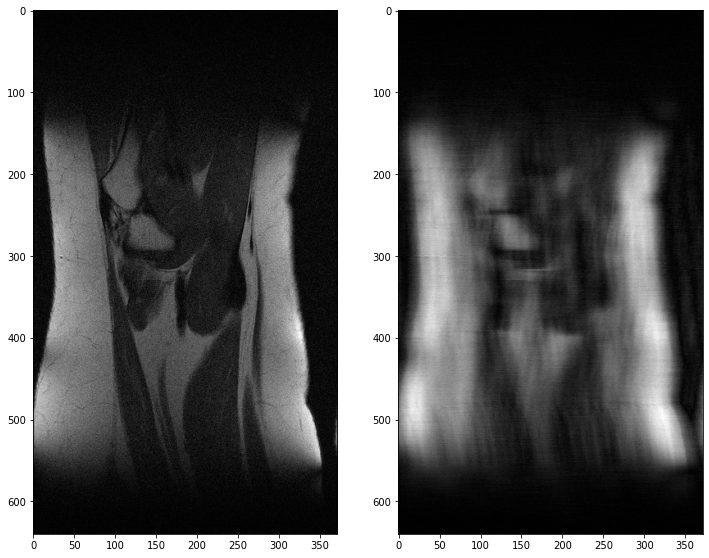

In [0]:
i = 30
show_imgs(img_items[i], crappified_imgs[i], ncols = 2, cmap = plt.get_cmap('gray'))

# Model

In [0]:
bs,size=16,64
arch = resnet34

In [0]:
def get_items(): return range(len(img_items))
def get_x(i): return img_items[i]
def get_y(i): return crappified_imgs[i]

idxs = list(range(len(img_items)))

In [0]:
def get_dls(bs,size):
    dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), ImageBlock(cls=PILImageBW)),
                   get_x      = get_x,
                   get_y      = get_y,
                   splitter   = RandomSplitter(),
                   item_tfms  = Resize(size),
                   batch_tfms =[Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(idxs, bs=bs, item_tfms = Resize(size))         
    dls.c = 3
    return dls

In [0]:
%time
dls = get_dls(bs,size)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 5.25 µs


In [0]:
b = dls.train.one_batch()
b = dls.train.decode(b)
b[0].shape, b[1].shape

(torch.Size([16, 3, 64, 64]), torch.Size([16, 3, 64, 64]))

In [0]:
i = 10

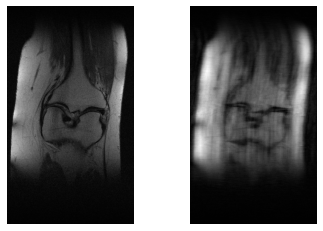

In [0]:
_, (ax1, ax2) = plt.subplots(1,2)
show_image(dls.train_ds[i][0], ax=ax1, cmap="gray")
show_image(dls.train_ds[i][1], ax=ax2, cmap="gray")

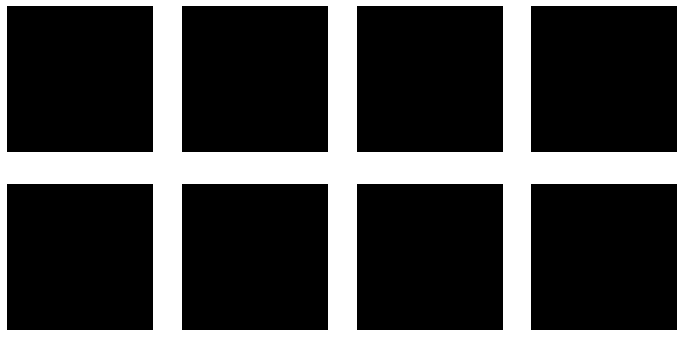

In [0]:
dls.show_batch(nrows=2, max_n=4, cmap='gray')

## Feature loss

In [0]:
tensor(dls.train_ds[0][1]).unsqueeze(0).shape

torch.Size([1, 640, 372])

In [0]:
tensor(dls.valid_ds[0][1]).unsqueeze(0).shape

torch.Size([1, 640, 372])

In [0]:
t = tensor(dls.valid_ds[0][1]).unsqueeze(0).float()/255.
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [0]:
t.shape

torch.Size([2, 1, 640, 372])

In [0]:
gram_matrix(t)

tensor([[[6.7686e-14]],

        [[6.7686e-14]]])

In [0]:
base_loss = F.l1_loss

In [0]:
vgg_m = vgg16_bn(True).features.cuda().eval()
vgg_m = vgg_m.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [0]:
class FeatureLoss(Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target, reduction='mean'):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target,reduction=reduction)]
        self.feat_losses += [base_loss(f_in, f_out,reduction=reduction)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out),reduction=reduction)*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        if reduction=='none': 
            self.feat_losses = [f.mean(dim=[1,2,3]) for f in self.feat_losses[:4]] + [f.mean(dim=[1,2]) for f in self.feat_losses[4:]]
        for n,l in zip(self.metric_names, self.feat_losses): setattr(self, n, l)
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [0]:
learn = unet_learner(dls, arch, loss_func=feat_loss, metrics=LossMetrics(feat_loss.metric_names),
                     config=unet_config(blur=True, norm_type=NormType.Weight)).to_fp16()

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0002290867705596611)

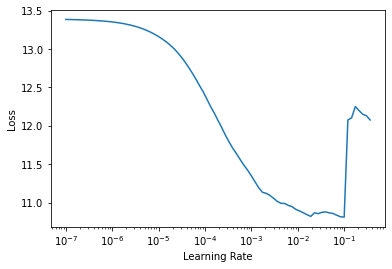

In [0]:
learn.lr_find()

In [0]:
lr = 1e-3
wd = 1e-3

In [0]:
PROJ_PATH

Path('/content/drive/My Drive/fastai_proj/fastmri')

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start, wd=wd)
    learn.save(PROJ_PATH/"models"/save_name)
    learn.show_results(ds_idx=1, max_n=2, figsize=(15,11))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,8.558158,10.405705,0.849815,0.303462,0.606159,0.050786,1.752682,6.821341,0.021461,00:05
1,6.534015,5.832345,0.462697,0.229505,0.416880,0.019872,1.226213,3.471111,0.006066,00:05
2,5.503446,4.380193,0.365372,0.205400,0.346634,0.015223,1.034514,2.408453,0.004597,00:05
3,4.924154,4.046609,0.243320,0.222179,0.331426,0.011734,1.074772,2.159955,0.003223,00:05
4,4.625282,7.569997,0.384764,0.248779,0.483399,0.033495,1.329282,5.076664,0.013613,00:05
5,4.729697,4.497849,0.539911,0.209204,0.346934,0.012557,1.018190,2.367366,0.003687,00:05
6,4.665125,5.194963,0.304647,0.203461,0.380625,0.019415,0.970524,3.310239,0.006052,00:05
7,4.462432,4.432972,0.323281,0.200180,0.364557,0.014140,0.952716,2.573755,0.004345,00:05
8,4.141223,2.873810,0.118102,0.135806,0.252671,0.010714,0.602606,1.751022,0.002889,00:05
9,3.294356,1.580121,0.047898,0.090821,0.160137,0.006318,0.336952,0.936304,0.001690,00:05


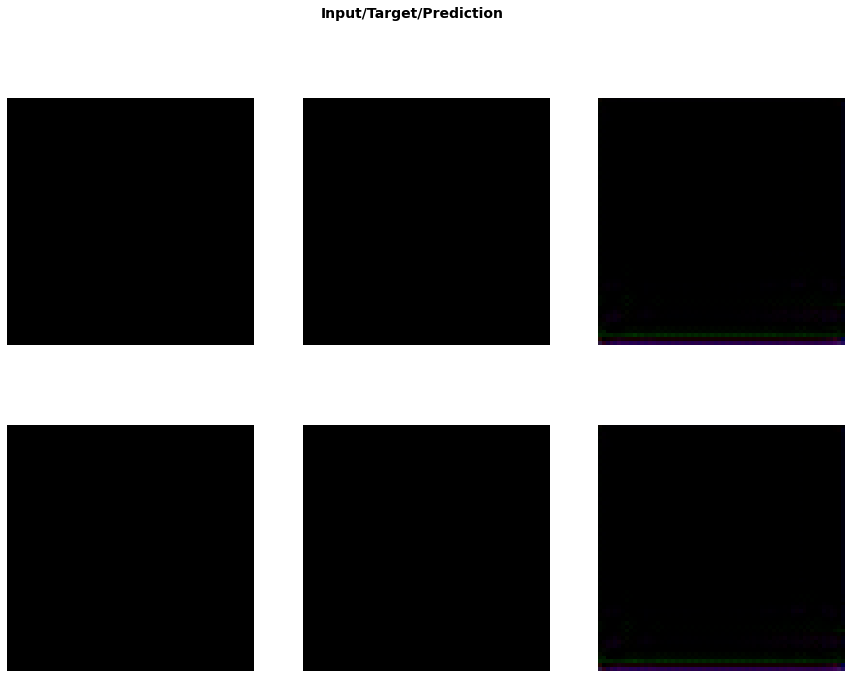

In [0]:
do_fit('1a', slice(lr*10))

In [0]:
learn.load('1a');

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.492769,1.356603,0.046456,0.084273,0.142375,0.005613,0.309917,0.766569,0.001400,00:06
1,1.321127,1.119862,0.041371,0.071800,0.115573,0.004300,0.267075,0.618710,0.001033,00:06
2,1.108594,0.771636,0.032041,0.052076,0.078512,0.002845,0.189407,0.416050,0.000706,00:06
3,0.868530,0.540140,0.022068,0.037790,0.053988,0.002044,0.134559,0.289160,0.000532,00:06
4,0.679833,0.552593,0.020930,0.031844,0.052358,0.001818,0.122593,0.322576,0.000474,00:06
5,0.682025,0.499259,0.014730,0.029277,0.047931,0.002014,0.104773,0.300059,0.000476,00:06
6,0.564364,0.429447,0.011361,0.024113,0.042508,0.001664,0.088953,0.260441,0.000406,00:06
7,0.560159,0.438759,0.019513,0.022827,0.037043,0.001397,0.085726,0.271895,0.000359,00:06
8,0.480713,0.325081,0.010822,0.019567,0.029447,0.000998,0.068997,0.194999,0.000252,00:06
9,0.374827,0.203003,0.007569,0.016013,0.021402,0.000664,0.051928,0.105258,0.000170,00:06


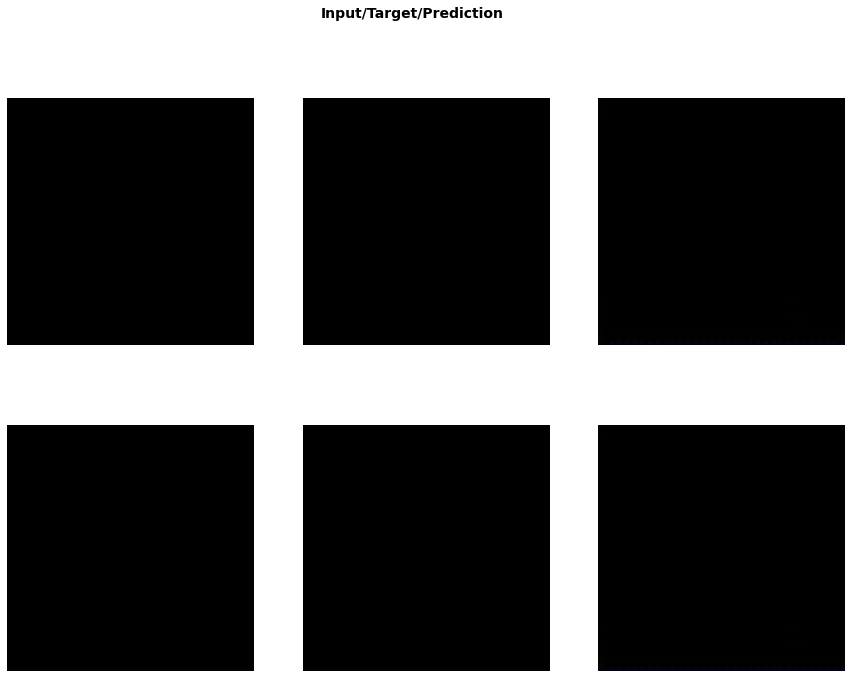

In [0]:
do_fit('1b', slice(1e-5,lr))

In [0]:
dls = get_dls(12,size*2)

In [0]:
learn.dls = dls
learn.freeze()

In [0]:
learn.load(PROJ_PATH/"models"/'1b');

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.934226,0.826833,0.013688,0.034257,0.099389,0.003626,0.152457,0.522596,0.000820,00:13
1,0.715467,0.340595,0.007321,0.018899,0.040001,0.001345,0.070821,0.201945,0.000262,00:10
2,0.405486,0.140811,0.005054,0.010076,0.017213,0.000512,0.036950,0.070911,0.000096,00:10
3,0.251067,0.143180,0.006626,0.009630,0.015859,0.000425,0.041175,0.069391,0.000073,00:10
4,0.217202,0.161282,0.006431,0.009903,0.017632,0.000472,0.042514,0.084251,0.000080,00:10
5,0.197545,0.145049,0.005747,0.008741,0.015917,0.000427,0.036247,0.077897,0.000073,00:10
6,0.205971,0.295731,0.022429,0.013430,0.026690,0.000807,0.070140,0.162101,0.000135,00:10
7,0.249239,0.192347,0.006367,0.010927,0.019966,0.000610,0.054414,0.099951,0.000112,00:09
8,0.258104,0.200227,0.007518,0.010121,0.019878,0.000615,0.047857,0.114121,0.000117,00:10
9,0.194456,0.098556,0.004540,0.007398,0.011945,0.000296,0.030163,0.044161,0.000052,00:10


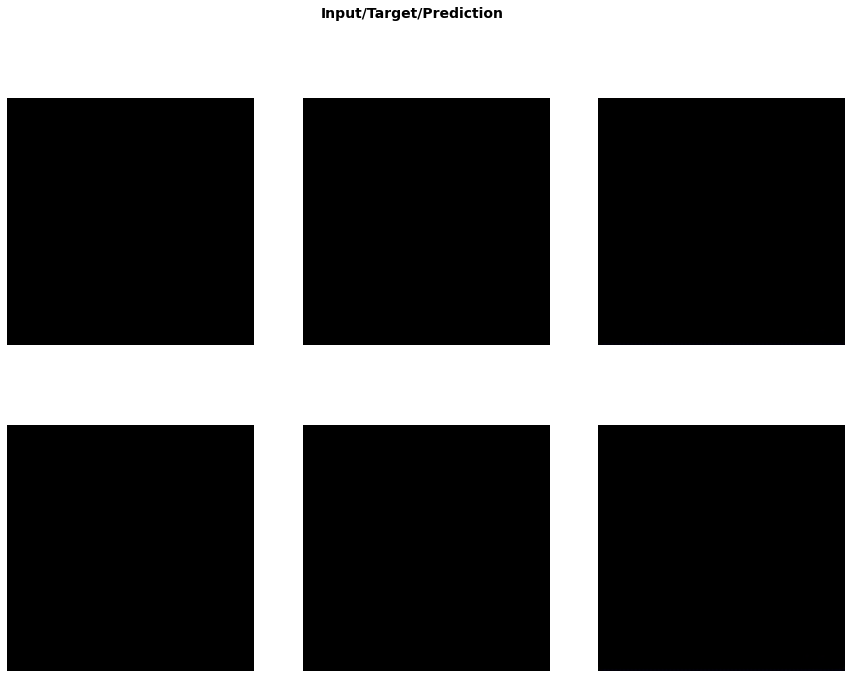

In [0]:
do_fit('2a')

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.109580,0.155062,0.003790,0.011042,0.016592,0.000434,0.062936,0.060204,0.000065,00:11
1,0.106833,0.086032,0.003099,0.006731,0.010572,0.000269,0.027112,0.038206,0.000044,00:10
2,0.106820,0.086855,0.003602,0.006539,0.010672,0.000289,0.025500,0.040201,0.000052,00:10
3,0.111868,0.096990,0.004535,0.007087,0.011443,0.000299,0.027910,0.045670,0.000047,00:11
4,0.104688,0.087723,0.004027,0.006859,0.010583,0.000276,0.027689,0.038241,0.000048,00:10
5,0.103081,0.085766,0.004396,0.006536,0.010356,0.000263,0.025833,0.038343,0.000040,00:10
6,0.103016,0.098549,0.005753,0.007601,0.011467,0.000278,0.032782,0.040621,0.000047,00:11
7,0.100949,0.091855,0.004550,0.006794,0.010585,0.000255,0.029875,0.039751,0.000044,00:10
8,0.102767,0.119840,0.005599,0.009072,0.013334,0.000325,0.042670,0.048785,0.000054,00:11
9,0.103165,0.102974,0.004562,0.008083,0.012212,0.000323,0.037808,0.039939,0.000047,00:11


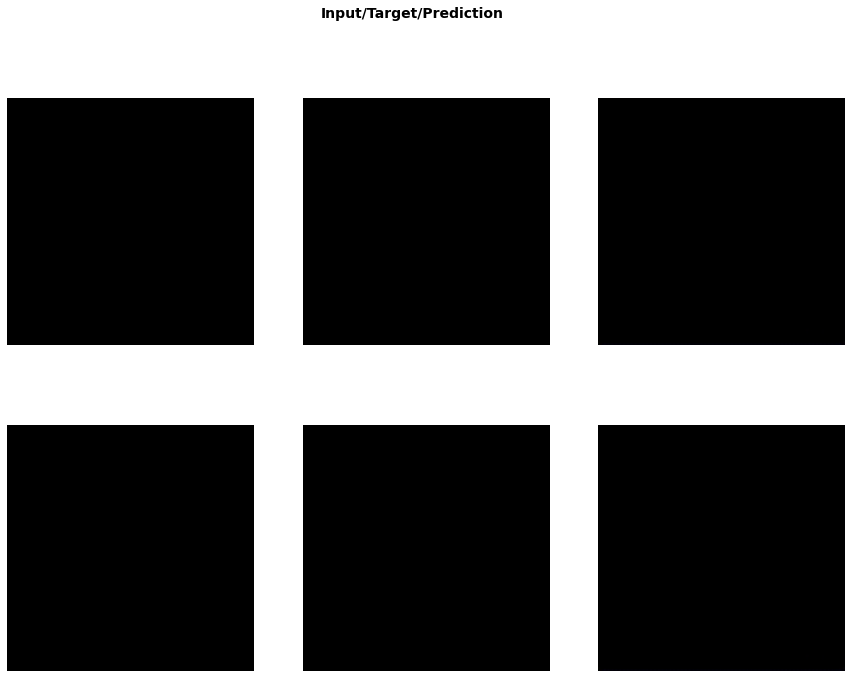

In [0]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [0]:
dls.train_ds[0]

(PILImageBW mode=F size=372x640, PILImageBW mode=F size=372x640)

In [0]:
i = 0
x,y = dls.train_ds[i]
pred, loss, prob = learn.predict(x);

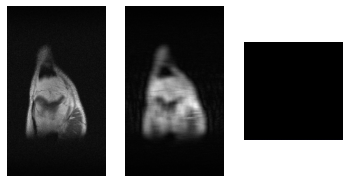

In [0]:
_, (ax1, ax2, ax3) = plt.subplots(1,3)
show_image(x, ax=ax1, cmap="gray")
show_image(y, ax=ax2, cmap="gray")
show_image(pred, ax=ax3, cmap="gray")

# Git Push

In [0]:
PROJ_PATH

Path('/content/drive/My Drive/fastai_proj/fastmri')

In [0]:
%cd "$PROJ_PATH"

/content/drive/My Drive/fastai_proj/fastmri


In [0]:
!git pull  # Refresh repo

Already up to date.


In [0]:
!git rm -r --cached .

fatal: pathspec '.' did not match any files


In [0]:
!git status        # Check statuses of changed files
!git add --all     # Add/track files
!git commit -am "feature loss - pred not showing" # Commit msg

On branch master
Your branch is ahead of 'origin/master' by 4 commits.
  (use "git push" to publish your local commits)

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	deleted:    .gitignore
	deleted:    01-superres.ipynb
	deleted:    common_setup.ipynb
	deleted:    fastmri.ipynb
	deleted:    gcp_untar.ipynb
	deleted:    models/1a.pth
	deleted:    models/1b.pth
	deleted:    models/2a.pth
	deleted:    models/2b.pth
	deleted:    notes/01_notes_FastMRI.ipynb
	deleted:    notes/ideas.ipynb
	deleted:    notes/imgs/2d.png
	deleted:    notes/imgs/Fourier transform.png
	deleted:    notes/imgs/_459970_orig.jpg
	deleted:    notes/imgs/alias.png
	deleted:    notes/imgs/directions.png
	deleted:    notes/imgs/discrete_vs_cont.png
	deleted:    notes/imgs/einstein.png
	deleted:    notes/imgs/kspace_point.png
	deleted:    notes/imgs/kspace_to_image.jpg
	deleted:    notes/imgs/mxy.jpg
	deleted:    notes/imgs/net_m.gif
	deleted:    notes/imgs/phase_encoding.png
	deleted:    not

In [0]:
!git push origin master # Push changes to Github repo

Counting objects: 31, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (31/31), done.
Writing objects: 100% (31/31), 545.19 MiB | 4.54 MiB/s, done.
Total 31 (delta 12), reused 0 (delta 0)
remote: Resolving deltas: 100% (12/12), completed with 2 local objects.
remote: error: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
remote: error: Trace: 275e218c877b3a8cd6bcd9415f172464
remote: error: See http://git.io/iEPt8g for more information.
remote: error: File models/1a.pth is 309.74 MB; this exceeds GitHub's file size limit of 100.00 MB
remote: error: File models/2b.pth is 472.00 MB; this exceeds GitHub's file size limit of 100.00 MB
remote: error: File models/1b.pth is 472.00 MB; this exceeds GitHub's file size limit of 100.00 MB
remote: error: File models/2a.pth is 472.00 MB; this exceeds GitHub's file size limit of 100.00 MB
To https://github.com/rgologorsky/fastmri
 ! [remote rejected] master -> master (pre-r

In [0]:
# !rm .git/index.lock

rm: cannot remove '.git/index.lock': No such file or directory
